**МНК различными методами**

In [ ]:
from numpy import array
from numpy.linalg import inv
from matplotlib import pyplot
from numpy.linalg import qr
from numpy.linalg import pinv
# двумерный массив входных данных
data = array([
	[0.05, 0.12],
	[0.18, 0.22],
	[0.31, 0.35],
	[0.42, 0.38],
	[0.5, 0.49],
	])
X, y = data[:,0], data[:,1]
X = X.reshape((len(X), 1))

[1.00233226]


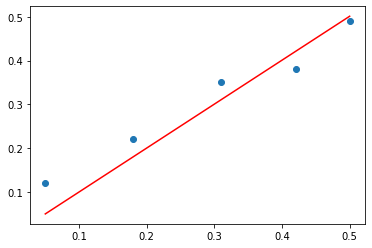

In [ ]:
# решаем прямым обращением матрицы
b = inv(X.T.dot(X)).dot(X.T).dot(y)
print(b)
# получаем оценку y
yhat = X.dot(b)

pyplot.scatter(X, y)
pyplot.plot(X, yhat, color='red')
pyplot.show()

[1.00233226]


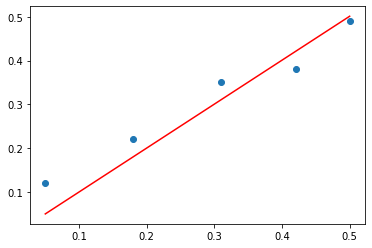

In [ ]:
# МНК через QR-разложение
Q, R = qr(X)
b = inv(R).dot(Q.T).dot(y)
print(b)
# получаем оценку y
yhat = X.dot(b)

pyplot.scatter(X, y)
pyplot.plot(X, yhat, color='red')
pyplot.show()

[1.00233226]


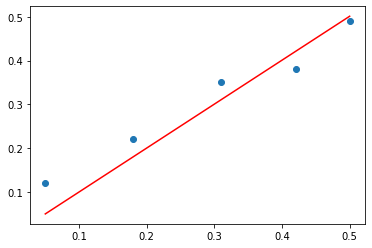

In [ ]:
# МНК через SVD-разложение (используется специально предназначенная функция pinv())
b = pinv(X).dot(y)
print(b)
# получаем оценку y
yhat = X.dot(b)

pyplot.scatter(X, y)
pyplot.plot(X, yhat, color='red')
pyplot.show()

**МНК средствами Python**

Unweighted fit parameters: [34.10688702  4.          7.61608921]
Covariance matrix:
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]
rms error in fit: 28.428531428920717



/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


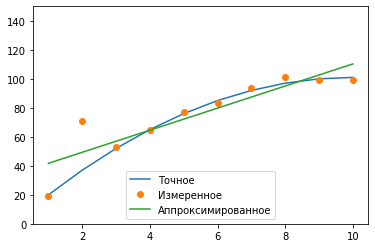

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import pylab

x0, A, gamma = 1, -1, 20

n = 10
x = np.linspace(1, 10, n)
yexact = A*(x)**2 + gamma*(x) + x0

# Add some noise with a sigma of 0.5 apart from a particularly noisy region
# near x0 where sigma is 3
sigma = 2*np.ones(n)
noise = np.random.randn(n) * sigma
y = yexact + noise
y[1] = y[1]*2             # моделируем выброс

def f(x, x0, A, gamma):
    """ The Lorentzian entered at x0 with amplitude A and HWHM gamma. """
    return 0*x**3 + 0*A*(x)**2 + gamma*(x) + x0

def rms(y, yfit):
    return np.sqrt(np.sum((y-yfit)**2))

# Unweighted fit
p0 = 0, 4, 2
popt, pcov = curve_fit(f, x, y, p0)
yfit = f(x, *popt)
print('Unweighted fit parameters:', popt)
print('Covariance matrix:'); print(pcov)
print('rms error in fit:', rms(yexact, yfit))
print()

pylab.plot(x, yexact, label='Точное')
pylab.plot(x, y, 'o', label='Измеренное')
pylab.plot(x, yfit, label='Аппроксимированное')
pylab.ylim(0,150)
pylab.legend(loc='lower center')
pylab.show()

**Итерационный МНК для определения местоположения маячка** <br>
Имеется задача определить местоположение сотрудника в здании. Сотрудник обязан носить бэйдж со встроенным маяком, сигнал которого принимается дальномерными точками, расставленными по этажу.
С помощью МНК находятся координаты объекта с маячком в каждый момент времени, используя на входе дальности от дальномерных точек до маячка.

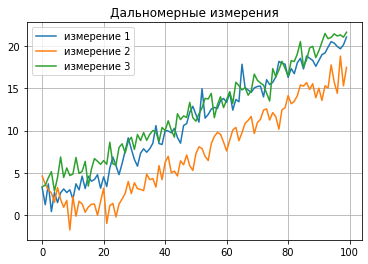

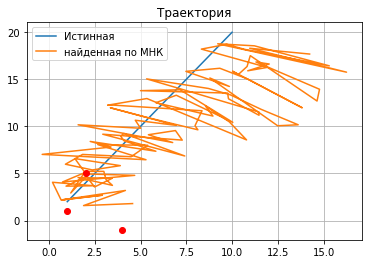

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# нелинейная функция измерений (или по-другому приближаемая функция)
# х - параметр аппроксимирующей функции, который требуется найти с помощью МНК
def h(x, p):
  return np.sqrt((x[0]-p[0])**2 + (x[1]-p[1])**2)

# группировка аппроксимирующих функций по всем размерностям пространства входных данных
# Иначе - это получение многомерной функции для
def h_all(x,p):
  return np.array([h(x, p[0,:]),
                   h(x, p[1,:]),
                   h(x, p[2,:]) ])

#  Матрица Якоби нелинейного преобразования (аппроксимирующей функции)
def jac(x, p):
  return np.array([(x[0]-p[0])/np.sqrt((x[0]-p[0])**2 + (x[1]-p[1])**2), 
                   (x[1]-p[1])/np.sqrt((x[0]-p[0])**2 + (x[1]-p[1])**2) ])
  
# Группировка Якобианов
def jac_all(x, p):
    return np.array([jac(x, p[0,:]),
                     jac(x, p[1,:]),
                     jac(x, p[2,:]) ])

#-------------------------------------------------------------------------------

N = 100;                    # количество измерений траектории
x0 = np.array([1, 2])       # начальная позация объекта
x_max = np.array([10, 20])  # конечная позиция объекта
trajectory = np.linspace(x0, x_max, N)  # двумерный вектор траектории объекта (равномерная прямолинейная траектория)

# Координаты дальномерных точек
point_crd_1 = np.array([1, 1])
point_crd_2 = np.array([2, 5])
point_crd_3 = np.array([4, -1])
points_crd = np.array([point_crd_1, point_crd_2, point_crd_3]) # многомерный вектор всех координат точек

sigma = 1; # СКО ошибок измерений дальности до объекта

# Измерения дальностей от дальномерных точек до объекта
measurement_1 = [h(x, point_crd_1) + sigma*np.random.randn()    for x in trajectory]
measurement_2 = [h(x, point_crd_2) + sigma*np.random.randn()    for x in trajectory]
measurement_3 = [h(x, point_crd_3) + sigma*np.random.randn()    for x in trajectory]
measurements = np.array([measurement_1, measurement_2, measurement_3])               # все измерения

k=0.1                    # постоянная сходимости
result = np.zeros([2,N])  # двумерный вектор найденной траектории

#-------------------------------------------------------------------------------

# Ищем местоположения объекта по всей траектории
for j in range(N):
  x = np.array([10., 10.]) #
  # Ищем местоположение объекта в текущей точке с помощью МНК
  for i in range(200):
    x = x + k*jac_all(x, points_crd).T.dot(measurements[:, j] - h_all(x, points_crd).T) # МНК в лоб, используя Якобиан
    result[:,j] = x # записали текущую позицию

#-------------------------------------------------------------------------------

# рисуем графики
plt.title('Дальномерные измерения')
plt.plot(measurement_1)
plt.plot(measurement_2)
plt.plot(measurement_3)
plt.legend(['измерение 1','измерение 2','измерение 3'])
plt.grid()
plt.show()

plt.title('Траектория')
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(result[0,:], result[1,:])
plt.legend(['Истинная','найденная по МНК'])
plt.plot(point_crd_1[0],point_crd_1[1], 'ro--')
plt.plot(point_crd_2[0],point_crd_2[1], 'ro--')
plt.plot(point_crd_3[0],point_crd_3[1], 'ro--')
plt.grid()
plt.show()


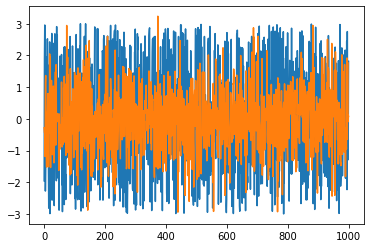

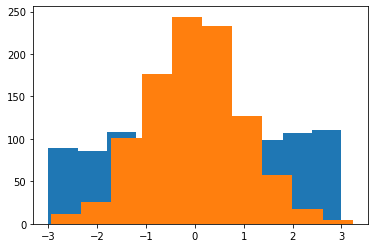

In [ ]:
# Моделирование случайной величины
import numpy as np
import matplotlib.pyplot as plt
x = 6*(np.random.rand(1000)-0.5)
y = np.random.randn(1000)
plt.plot(x)
plt.plot(y)
plt.show()
plt.hist(x)
plt.hist(y)
plt.show()

In [ ]:
import numpy as np
A = np.array([[1, 0], [1, -1]])
np.linalg.det(A)

-1.0